Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use keras.layers.Flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

INFO:tensorflow:Restoring parameters from checkpoint/network10.ckpt
done
--------------------------------------------------------------------------------
Top 5 Predictions
--------------------------------------------------------------------------------


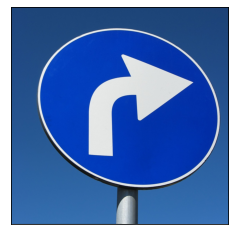

33: Turn right ahead                                   (100.0000000000%)
   37: Go straight or left                                (  0.0000000000%)
   39: Keep left                                          (  0.0000000000%)
   35: Ahead only                                         (  0.0000000000%)
   40: Roundabout mandatory                               (  0.0000000000%)
--------------------------------------------------------------------------------


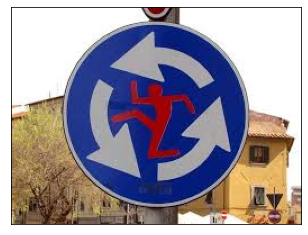

40: Roundabout mandatory                               ( 86.8458092213%)
   25: Road work                                          ( 12.7475991845%)
   38: Keep right                                         (  0.2534227213%)
   36: Go straight or right                               (  0.1245408086%)
   11: Right-of-way at the next intersection              (  0.0196993860%)
--------------------------------------------------------------------------------


In [1]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # disable INFO and WARNING Tensorflow messages
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
from tensorflow.compat.v1.layers import flatten
from pipeline import NeuralNetwork, Session, build_pipeline
import time


def load_image(image_file):
    """
    Read image file into numpy array (RGB)
    """
    return plt.imread(image_file)


sign_name_df = pd.read_csv('sign_names.csv', index_col='ClassId')
SIGN_NAMES = sign_name_df.SignName.values
N_CLASSES = len(SIGN_NAMES)


INPUT_SHAPE = (32, 32, 3)
def make_network10(input_shape=INPUT_SHAPE):
    return (NeuralNetwork()
            .input(input_shape)
            .conv([5, 5, 24])
            .max_pool()
            .relu()
            .conv([5, 5, 64])
            .max_pool()
            .relu()
            .dropout(keep_prob=0.5)
            .flatten()
            .dense(480)
            .relu()
            .dense(N_CLASSES))


def resize_image(image, shape=INPUT_SHAPE[:2]):
    return cv2.resize(image, shape)


loader = lambda image_file: resize_image(load_image(image_file))
normalizer = lambda x: (x - x.mean())/x.std()
augmenter = lambda x: x


preprocessors = [loader, augmenter, normalizer]

X_new = np.array(glob.glob('sign*.jpg') + 
                 glob.glob('sign*.png') +
                 glob.glob('sign*.jfif')
                 )

new_images = [plt.imread(path) for path in X_new]

session = Session()
pipeline = build_pipeline(preprocessors, session, make_network10())
session.load('checkpoint/network10.ckpt')  
prob = pipeline.predict_proba(X_new)
estimator = pipeline.steps[-1][1]
top_5_prob, top_5_pred = estimator.top_k_

print('done')

print('-' * 80)
print('Top 5 Predictions')
print('-' * 80)

for i, (preds, probs, image) in enumerate(zip(top_5_pred, top_5_prob, new_images)):
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    for pred, prob in zip(preds.astype(int), probs):
        sign_name = SIGN_NAMES[pred]
        print('{:>5}: {:<50} ({:>14.10f}%)'.format(pred, sign_name, prob*100.0))
    print('-' * 80)



ValueError: No variables to save